# Thematic differences (Ukraine)

DHH23 Parliament group

Author: Pontus H.

In [138]:
# Set the theme here
THEME = 'healthcare_UA'
# Set the output path for the CSV:s and keyword figure
OUTPUT_PATH = '../thematic_differences/'
# Set the output path for the model
MODEL_PATH = '../data/models/'

In [139]:
from cuml.manifold import UMAP
from cuml.cluster.hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

import pandas as pd
import numpy as np

In [140]:
# Optional stopwords
with open('../data/stopwords-ua.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

Set up the BERTopic pipeline

In [141]:
df = pd.read_csv(f'../data/{THEME}.csv')
df.head()

,ID,Title,Date,Body,Term,Session,Meeting,Sitting,Agenda,Subcorpus,...,Speaker_party,Speaker_party_name,Party_status,Speaker_name,Speaker_gender,Speaker_birth,speech,speech_split,sentiment,speech_length
0,ParlaMint-UA_2017-01-18-m0.u10,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,фОпоблок,"Фракція політичної партії ""Опозиційний блок""",Opposition,"Валерійович Долженков, Олександр",M,1983.0,"Шановні колеги, шановні громадяни України! Тут...","Так, дійсно, ми не підтримуємо цю децентраліз...",-0.600586,5277
1,ParlaMint-UA_2017-01-18-m0.u71,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-01-18,Unicameralism,8,5,NaN,2017-01-18,NaN,Reference,...,фЛяшко,Фракція Радикальної партії Олега Ляшка,Opposition,"Валерійович Ляшко, Олег",M,1972.0,"Олег Ляшко, Радикальна партія. Шановні колеги,...","Шановні колеги, звідки беруться бездомні, хто...",-1.000000,2579
2,ParlaMint-UA_2017-03-21-m1.u4,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-03-21,Unicameralism,8,6,NaN,2017-03-21,NaN,Reference,...,фОС,Фракція політичної партії «Об'єднання „Самопом...,Opposition,"Володимирівна Сисоєнко, Ірина",F,1982.0,У мене запитання до представника Міністерства ...,"Скажіть, будь ласка, в діючій редакції Закону...",-0.785156,680
3,ParlaMint-UA_2017-03-21-m1.u27,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-03-21,Unicameralism,8,6,NaN,2017-03-21,NaN,Reference,...,фОС,Фракція політичної партії «Об'єднання „Самопом...,Opposition,"Володимирівна Сисоєнко, Ірина",F,1982.0,"Фракція ""Об'єднання ""Самопоміч"" буде підтримув...",В нормах цього законопроекту є нові редакції ...,0.429199,2267
4,ParlaMint-UA_2017-03-21-m1.u33,"Ukrainian parliamentary corpus ParlaMint-UA, t...",2017-03-21,Unicameralism,8,6,NaN,2017-03-21,NaN,Reference,...,фЛяшко,Фракція Радикальної партії Олега Ляшка,Opposition,"Валерійович Ляшко, Олег",M,1972.0,"Олег Ляшко, Радикальна партія. Мене взагалі ди...",Мене взагалі дивує реакція головуючої в парла...,-0.932617,4373


In [142]:
# Parameters
HDBSCAN_MIN_CLUSTER_SIZE = 20 # int(np.sqrt(len(df)))
HDBSCAN_MIN_SAMPLES = 1
HDBSCAN_CLUSTER_SELECTION_EPSILON = 0
OUTLIER_THRESHOLD = 0.1

# Step 1 - Extract embeddings
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2') # English
embedding_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2') # Other languages

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(
    min_cluster_size=HDBSCAN_MIN_CLUSTER_SIZE,
    min_samples=HDBSCAN_MIN_SAMPLES,
    cluster_selection_epsilon=HDBSCAN_CLUSTER_SELECTION_EPSILON,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True,)

# Step 3 - Cluster reduced embeddings with KMeans
# hdbscan_model = KMeans(n_clusters=100, random_state=42)

# Step 4 - Tokenize topics
# vectorizer_model = CountVectorizer(stop_words="english") # English
vectorizer_model = CountVectorizer(stop_words=stopwords) # Other languages

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

# Step 6 - (Optional) Fine-tune topic representations with 
# a `bertopic.representation` model
# representation_model = KeyBERTInspired()
representation_model = MaximalMarginalRelevance(diversity=0.8)

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  # nr_topics=10,
  calculate_probabilities=True,
  n_gram_range=(1, 3)
)

In [143]:
HDBSCAN_MIN_CLUSTER_SIZE

20

In [144]:
df['Speaker_party'].value_counts()

фВОБ        493
фЛяшко      396
фСН         374
фБПП        374
фОпоблок    314
фЄС         298
фОПЗЖ       290
фОС         287
фПГ         227
гДовіра     195
гЗМП        144
фНФ         132
гПВ          92
фСвобода     70
фУДАР        58
фПР          50
гЕР          50
гВН          36
гСЄУ         30
гЗМіС        12
гЗМ           8
НФ            7
Свобода       4
фБЮТ          2
np2           1
фКПУ          1
УСГ           1
Name: Speaker_party, dtype: int64

In [145]:
# Reference running time for this cell: 0min 30s
topics, probs = topic_model.fit_transform(df['speech'])


In [146]:
pd.Series(topics).value_counts()

-1     910
 0     505
 1     430
 2     341
 3     137
 4     120
 5     116
 6      99
 7      82
 8      79
 9      76
 12     72
 11     72
 10     72
 13     70
 14     69
 15     62
 16     61
 17     59
 18     58
 19     56
 20     55
 21     52
 22     50
 23     43
 24     42
 25     41
 26     36
 27     35
 28     32
 29     32
 31     31
 30     31
 32     30
 34     29
 33     29
 35     28
 36     27
 38     27
 37     27
 40     26
 39     26
 41     25
 43     25
 42     25
 45     24
 44     24
 47     23
 46     23
 49     21
 48     21
 50     20
 52     20
 51     20
dtype: int64

In [147]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(df['speech'], topics, strategy="c-tf-idf", threshold=OUTLIER_THRESHOLD)

In [148]:
pd.Series(new_topics).value_counts()

-1     744
 0     542
 1     443
 2     342
 3     168
 5     134
 4     121
 6     101
 7      89
 9      82
 8      80
 10     76
 12     75
 13     73
 11     73
 14     70
 15     66
 16     66
 17     63
 18     58
 19     57
 20     56
 21     52
 22     50
 24     47
 23     43
 25     41
 26     39
 27     35
 35     35
 28     32
 30     32
 29     32
 31     31
 32     30
 34     30
 33     30
 37     27
 36     27
 40     27
 38     27
 39     27
 43     25
 42     25
 41     25
 45     24
 44     24
 47     23
 46     23
 50     21
 49     21
 52     21
 48     21
 51     20
dtype: int64

In [149]:
# Number of topics
print(f"Number of topics: {len(pd.Series(topics).unique())}")

Number of topics: 54


In [150]:
# The count of speeches per topic. -1 is the noise(outlier) topic
pd.Series(topic_model.hdbscan_model.labels_).value_counts()

-1     910
 24    505
 41    430
 26    341
 37    137
 29    120
 33    116
 50     99
 1      82
 7      79
 47     76
 0      72
 16     72
 11     72
 51     70
 12     69
 36     62
 5      61
 32     59
 40     58
 19     56
 27     55
 43     52
 17     50
 23     43
 42     42
 14     41
 46     36
 35     35
 22     32
 25     32
 44     31
 34     31
 3      30
 49     29
 4      29
 20     28
 30     27
 8      27
 9      27
 6      26
 39     26
 45     25
 13     25
 48     25
 2      24
 38     24
 15     23
 28     23
 10     21
 31     21
 21     20
 52     20
 18     20
dtype: int64

In [151]:
topic_model.visualize_topics()

In [152]:
topic_word_scores = topic_model.visualize_barchart(width=330, height=330, top_n_topics=10, n_words=10)
# Create the output directory if it does not exist
import os
if not os.path.exists(f"{OUTPUT_PATH}{THEME}"):
    os.makedirs(f"{OUTPUT_PATH}{THEME}")
topic_word_scores.write_image(f"{OUTPUT_PATH}{THEME}/{THEME}_topic_keywords.png")
topic_word_scores

# Word Clouds

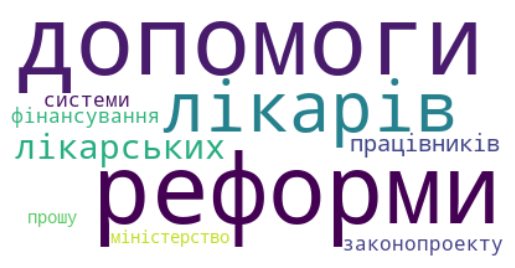

In [153]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=0)

For the top 10 topics, get the percentage of Labour speeches and Conservative speeches. Include the keywords related to the topic.

In [154]:
def get_keywords(topic):
    return [word for word, _ in topic_model.get_topic(topic)]
# get_keywords(0)

In [155]:
speech_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party']})
# Remove the noise topic
speech_topic_party = speech_topic_party[speech_topic_party['topic'] != -1]
# Remove topics > 10
speech_topic_party = speech_topic_party[speech_topic_party['topic'] < 10]
# Drop speeches with no party
speech_topic_party = speech_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
speech_topic_party.loc[speech_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
speech_topic_party.loc[~speech_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Group by party and topic
speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
speech_topic_party = speech_topic_party.pivot(index='topic', columns='party', values='counts').fillna(0)
#speech_topic_party.to_csv(f"{OUTPUT_PATH}{THEME}_speeches_topic_party.csv")
speech_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,316,70,96
1,210,59,73
2,181,77,45
3,101,14,21
4,53,25,23
5,79,24,19
6,45,24,20
7,36,30,2
8,56,12,7


In [156]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages = speech_topic_party.div(speech_topic_party.sum(axis=0), axis=1)
# Multiply by 100 to get percentages and round to 1 decimal
percentages = (percentages * 100).round(1)
percentages.reset_index()
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,28.4,19.7,30.9
1,18.9,16.6,23.5
2,16.3,21.6,14.5
3,9.1,3.9,6.8
4,4.8,7.0,7.4
5,7.1,6.7,6.1
6,4.0,6.7,6.4
7,3.2,8.4,0.6
8,5.0,3.4,2.3


In [157]:
# Reset the index to get the topic column back and add a new column 'keywords'
percentages = percentages.reset_index()
percentages['keywords'] = percentages['topic'].apply(lambda x: get_keywords(x))
percentages = percentages.set_index('topic')
#percentages.to_csv(f'{OUTPUT_PATH}{THEME}_percentages.csv')
percentages

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР,keywords
topic,,,,
0,28.4,19.7,30.9,"[допомоги, реформи, лікарів, лікарських, праці..."
1,18.9,16.6,23.5,"[парламент, партії, президента, вибори, україн..."
2,16.3,21.6,14.5,"[правку, медичних, законопроекту, охорони, під..."
3,9.1,3.9,6.8,"[комуналку, газу, радикальна, зростання, пенсі..."
4,4.8,7.0,7.4,"[хвилин, регламенту, подякувати, парламенту, о..."
5,7.1,6.7,6.1,"[бюджету, кодом, висновків, державного, мільяр..."
6,4.0,6.7,6.4,"[pfizer, вакцинувати, пане, 6297, міністре, на..."
7,3.2,8.4,0.6,"[мозку, кісткового, трансплантацію, кров, незг..."
8,5.0,3.4,2.3,"[піклування, типа, дитячих, оздоровлення, семь..."


In [158]:
# For each topic, divide the count of speeches by the total count of speeches per party
percentages_per_row = speech_topic_party.div(speech_topic_party.sum(axis=1), axis=0)
# Multiply by 100 to get percentages and round to 1 decimal
percentages_per_row = (percentages_per_row * 100).round(1)
# percentages_per_row.to_csv(f'{OUTPUT_PATH}{THEME}_percentages_per_row.csv')
percentages_per_row.reset_index()

party,topic,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
0,0,65.6,14.5,19.9
1,1,61.4,17.3,21.3
2,2,59.7,25.4,14.9
3,3,74.3,10.3,15.4
4,4,52.5,24.8,22.8
5,5,64.8,19.7,15.6
6,6,50.6,27.0,22.5
7,7,52.9,44.1,2.9
8,8,74.7,16.0,9.3
9,9,57.4,34.4,8.2


Calculate mean sentiment for each topic per party

In [159]:
# sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'party': df['Speaker_party'], 'sentiment': df['sentiment']})
sentiment_topic_party = pd.DataFrame({'topic': new_topics, 'speech_id': df['ID'], 'party': df['Speaker_party'], 'speaker_party': df['Speaker_party'], 'sentiment': df['sentiment'], 'speech_date': df['Date'], 'prob': list(probs), 'speech': df['speech']})
# Remove the noise topic
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] != -1]
# Remove topics > 10
sentiment_topic_party = sentiment_topic_party[sentiment_topic_party['topic'] < 10]
# Drop speeches with no party
sentiment_topic_party = sentiment_topic_party.dropna()
# Set the party name to 'фБПП.фЄС.фУДАР' if it contains 'фБПП', 'фЄС' or 'фУДАР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фБПП|фЄС|фУДАР'), 'party'] = 'фБПП.фЄС.фУДАР'
# Set the party name to 'фОПЗЖ.фОпоблок.фПР' if it contains 'фОПЗЖ', 'фОпоблок' or 'фПР'
sentiment_topic_party.loc[sentiment_topic_party['party'].str.contains('фОПЗЖ|фОпоблок|фПР'), 'party'] = 'фОПЗЖ.фОпоблок.фПР'
# Set the party name to 'OTHER' if the party name does not contain 'SDS' or 'SD'
sentiment_topic_party.loc[~sentiment_topic_party['party'].str.contains('фБПП.фЄС.фУДАР|фОПЗЖ.фОпоблок.фПР'), 'party'] = 'OTHER'
# Create a new dataframe with the relevant speeches and remove
relevant_speeches = sentiment_topic_party.copy()
sentiment_topic_party.drop(columns=['speech', 'speech_date', 'prob'], inplace=True)
# Group by party and topic and take the average sentiment
sentiment_topic_party = sentiment_topic_party.groupby(['topic', 'party']).mean().reset_index()
# speech_topic_party = speech_topic_party.groupby(['topic', 'party']).size().reset_index(name='counts')
# Pivot the dataframe
sentiment_topic_party = sentiment_topic_party.pivot(index='topic', columns='party', values='sentiment').fillna(0).round(2)
# sentiment_topic_party.to_csv(f'{OUTPUT_PATH}{THEME}_sentiment.csv')
sentiment_topic_party

party,OTHER,фБПП.фЄС.фУДАР,фОПЗЖ.фОпоблок.фПР
topic,,,
0,-0.28,-0.28,-0.46
1,-0.43,-0.52,-0.57
2,-0.29,-0.33,-0.47
3,-0.59,-0.59,-0.62
4,-0.47,-0.24,-0.64
5,-0.23,-0.13,-0.69
6,-0.57,-0.64,-0.62
7,-0.03,0.06,-0.88
8,-0.30,-0.22,-0.65


In [160]:
# Save the topic model
topic_model.save(f"{MODEL_PATH}{THEME}_topic_model.bin")

In [161]:
def get_top_3(topic_id, party_name):
    speeches_for_topic_0_con = relevant_speeches[(relevant_speeches['party'] == party_name) & (relevant_speeches['topic'] == topic_id)]
    speeches_for_topic_0_con['prob'] = speeches_for_topic_0_con['prob'].apply(lambda x: x[topic_id])
    speeches_for_topic_0_con = speeches_for_topic_0_con.sort_values(by='sentiment', ascending=False)
    most_positive = speeches_for_topic_0_con.head(3)
    most_negative = speeches_for_topic_0_con.tail(3)
    return most_positive.append(most_negative).drop_duplicates(subset=['speech_id'])

parties = ['фБПП.фЄС.фУДАР', 'фОПЗЖ.фОпоблок.фПР', 'OTHER']

max_topic = relevant_speeches['topic'].max()

representative_speeches = get_top_3(0, 'фБПП.фЄС.фУДАР')
for party in parties[1:]:
    representative_speeches = representative_speeches.append(get_top_3(0, party))
for topic_id in range(1,max_topic+1):
    for party in parties:
        representative_speeches = representative_speeches.append(get_top_3(topic_id, party))

# Save the representative speeches to a csv and feather file. Use '"" as the quotechar to avoid issues with the speech text
representative_speeches.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.csv', quotechar='"', index=False)
representative_speeches.reset_index().to_feather(f'{OUTPUT_PATH}{THEME}/{THEME}_representative_speeches.feather')
representative_speeches

,topic,speech_id,party,speaker_party,sentiment,speech_date,prob,speech
383,0,ParlaMint-UA_2017-11-14-m0.u136,фБПП.фЄС.фУДАР,фБПП,0.937012,2017-11-14,1.000000,Дякую. Я би хотіла звернутися до наших молдавс...
598,0,ParlaMint-UA_2017-06-08-m0.u104,фБПП.фЄС.фУДАР,фБПП,0.803711,2017-06-08,0.131378,"Сподіваюся на те, що наші діти захочуть йти у ..."
150,0,ParlaMint-UA_2017-02-08-m0.u88,фБПП.фЄС.фУДАР,фБПП,0.703125,2017-02-08,0.076422,"Шановні колеги, Комітет з питань охорони здоро..."
1037,0,ParlaMint-UA_2021-11-03-m0.u28,фБПП.фЄС.фУДАР,фЄС,-0.978516,2021-11-03,0.162790,"Шановний пане Голово, шановні колеги, хочу зве..."
1918,0,ParlaMint-UA_2013-05-15-m0.u156,фБПП.фЄС.фУДАР,фУДАР,-0.982422,2013-05-15,0.230850,"Павло Розенко, фракція ""УДАР"" Віталія Кличко""...."
...,...,...,...,...,...,...,...,...
969,9,ParlaMint-UA_2021-12-14-m0.u294,OTHER,гДовіра,0.730469,2021-12-14,0.070083,"Шановний пане Голово, шановні народні депутати..."
3585,9,ParlaMint-UA_2016-03-31-m0.u59,OTHER,фНФ,0.673828,2016-03-31,0.048101,"Колеги, доброго дня! Фракція ""Народного фронту..."
1226,9,ParlaMint-UA_2021-01-26-m0.u120,OTHER,фСН,-0.702637,2021-01-26,0.049854,"Олександр Качура, фракція ""Слуга народу"". Наша..."
3636,9,ParlaMint-UA_2018-04-17-m1.u46,OTHER,фЛяшко,-0.733887,2018-04-17,0.031082,"Приємно, що нарешті парламент почав обговорюва..."


In [162]:
# Create a new dataframe from percentages, percentages_per_row and sentiment_topic_party
concatenated_results = pd.concat([percentages, percentages_per_row, sentiment_topic_party], axis=1)
# Rename the columns to make it easier to understand
concatenated_results.columns = ['pf.OTHER', 'pf.фБПП.фЄС.фУДАР', 'pf.фОПЗЖ.фОпоблок.фПР', 'keywords', 'tc.OTHER', 'tc.фБПП.фЄС.фУДАР', 'tc.фОПЗЖ.фОпоблок.фПР', 's.OTHER', 's.фБПП.фЄС.фУДАР', 's.фОПЗЖ.фОпоблок.фПР']
# Reorder the columns
concatenated_results = concatenated_results[['keywords', 'tc.фБПП.фЄС.фУДАР', 'tc.фОПЗЖ.фОпоблок.фПР', 'tc.OTHER', 'pf.фБПП.фЄС.фУДАР', 'pf.фОПЗЖ.фОпоблок.фПР', 'pf.OTHER', 's.фБПП.фЄС.фУДАР', 's.фОПЗЖ.фОпоблок.фПР', 's.OTHER']]
# Save the results to a csv
concatenated_results.to_csv(f'{OUTPUT_PATH}{THEME}/{THEME}_results.csv')
concatenated_results

,keywords,tc.фБПП.фЄС.фУДАР,tc.фОПЗЖ.фОпоблок.фПР,tc.OTHER,pf.фБПП.фЄС.фУДАР,pf.фОПЗЖ.фОпоблок.фПР,pf.OTHER,s.фБПП.фЄС.фУДАР,s.фОПЗЖ.фОпоблок.фПР,s.OTHER
topic,,,,,,,,,,
0,"[допомоги, реформи, лікарів, лікарських, праці...",14.5,19.9,65.6,19.7,30.9,28.4,-0.28,-0.46,-0.28
1,"[парламент, партії, президента, вибори, україн...",17.3,21.3,61.4,16.6,23.5,18.9,-0.52,-0.57,-0.43
2,"[правку, медичних, законопроекту, охорони, під...",25.4,14.9,59.7,21.6,14.5,16.3,-0.33,-0.47,-0.29
3,"[комуналку, газу, радикальна, зростання, пенсі...",10.3,15.4,74.3,3.9,6.8,9.1,-0.59,-0.62,-0.59
4,"[хвилин, регламенту, подякувати, парламенту, о...",24.8,22.8,52.5,7.0,7.4,4.8,-0.24,-0.64,-0.47
5,"[бюджету, кодом, висновків, державного, мільяр...",19.7,15.6,64.8,6.7,6.1,7.1,-0.13,-0.69,-0.23
6,"[pfizer, вакцинувати, пане, 6297, міністре, на...",27.0,22.5,50.6,6.7,6.4,4.0,-0.64,-0.62,-0.57
7,"[мозку, кісткового, трансплантацію, кров, незг...",44.1,2.9,52.9,8.4,0.6,3.2,0.06,-0.88,-0.03
8,"[піклування, типа, дитячих, оздоровлення, семь...",16.0,9.3,74.7,3.4,2.3,5.0,-0.22,-0.65,-0.30
